<span style="float:right;"><b>Daniel Stevens</b></span>  
<span style="float:right;">Socorro E. Dominguez-Vidana</span>  
<span style="float:right;">Introduction to Machine Learning - Jan22Mar22</span>  
<span style="float:right;">07 Mar 2022</span>


# High Fat Cheese Detection
<b><i>Building a Binary Classification Model for Cheese Fat Content using Supervised Learning Techniques</i></b>

## 1. Introduction
2.4 million Canadians aged 20 and over are living with diagnosed heart disease (Public Health Agency of Canada, 2017). Of these 2.4 milion individuals, 12 die every hour from the disease (Public Health Agency of Canada, 2017). Although these statistics are grim, the progression of heart disease can be slowed through lifestyle changes (Public Health Agency of Canada, 2017). One lifestyle change recommended by the Heart and Stroke Foundation of Canada to help slow the progression of heart disease is dietary change aimed at reducing blood cholesterol levels (Eat to Lower Your Cholesterol, 2016). To achieve this, the organization recommends lowering total fat intake, suggesting people choose lower fat dairy products, including lower fat cheeses (Eat to Lower Your Cholesterol, 2016).

What cheeses are higher fat and thus belong to a group of cheeses that those suffering from heart disease should avoid? This is a binary classification problem. In this exercise, we will use supervised machine learning to develop a classification model aimed at detecting higher fat cheeses based on certain features the cheeses posess.

In developing our model, we will choose cheeses with the label of 'higher fat' to be the positive class. We will optimize our model based on recall, which is a measure of the ability of a model to detect the positive class. This means we are more concerned with identifying all higher fat cheeses (reducing false negatives) than misidentifying lower fat cheeses (reducing false positives).

Running cheeses with unknown fat content through this model would be a good first step in identifying higher fat cheeses, to be confirmed through more involved testing and added to a 'cheeses to avoid' list.

Let's start our model-building task by first exploring our data.

## 2. Exploratory Data Analysis

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import altair as alt
import scipy
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, validation_curve, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer, classification_report, plot_confusion_matrix
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import FunctionTransformer
from cheese_custom_functions import Base_SearchCV, print_best_validation, evaluate_best_model, cv_score_df

### 2.1 Read in Data
Let's begin our exploratory analysis by first reading our data into a pandas dataframe from the `cheese_data` csv file provided. The data was originally obtained from the Government of Canada's Open Data Portal, however, it has since been removed. The `cheese_data` csv file contains wrangled and cleaned data from the original data set.

In [3]:
cheese_df = pd.read_csv('../data/cheese_data.csv')
cheese_df.head(2)

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat


In [4]:
cheese_df.shape

(1042, 13)

The `cheese_data` data set contains 1042 observations with 13 columns. Each observation represents a unique Canadian-manufactured cheese and each column a unique feature. As the data set has been removed from the original data source, we do not have clear definitions as to what the data in each column represents nor information regarding how the data was collected. We will have to infer the meaning of the data from the column names and range of values contained in each. Upon inspection of the cheese_df dataframe, we have inferred the meanings of the columns as follows:

| Column Name               | Description                                                            |
|---------------------------|------------------------------------------------------------------------|
| `CheeseId`                | A unique Id number for the cheese                                      |
| `ManufacturerProvCode`    | A two-letter code representing the province of manufacture             |
| `ManufacturingTypeEn`     | The cheese's method of manufacture                                     |
|`MoisturePercent`          | The moisture content of the cheese expressed in percent                |
| `FlavourEn`               | Text describing the flavour profile of the cheese                      |
| `CharacteristicsEn`       | Text describing various physical characteristics of the cheese         |
| `Organic`                 | Binary classification indicating whether the cheese is organic or not  |
| `Category Type`           | The one of 6 possible categories into which the cheese falls           |
| `MilkTypeEn`              | The type of milk used to make the cheese                               |
| `MilkTreatmentTypeEn`     | The manner in which the milk was treated (or not) before manufacturing |
| `RindType`                | The type of rind the cheese has                                        |
| `CheeseName`              | The name of the cheese                                                 |
| `FatLevel`                | A categorical description of the cheese's fat content                  |


### 2.2 Split Data into Train and Test Sets
Before we split our data set into train and test sets to ensure we are adhering to the golden rule of machine learning, let's check to see if there is a class imbalance in our target as this will influence how we split the data.

In [8]:
cheese_df['FatLevel'].value_counts()

lower fat     684
higher fat    358
Name: FatLevel, dtype: int64

It appears there is a class imbalance in our dataset. 'lower fat' appears to have almost twice as many examples as 'higher fat'. To ensure we get a more accurate evaluation of our model, we will pass our target column to the stratify argument of train_test_split. This will result in the train and test sets each having the same 'higher fat' to 'lower fat' proportions.

In [9]:
# Split dataframe into train and test sets
train_df,test_df=train_test_split(cheese_df,test_size=0.2,random_state=777, stratify=cheese_df['FatLevel'])
print('Train Shape:' + str(train_df.shape))
print(train_df['FatLevel'].value_counts(normalize=True))
print()
print('Test Shape:' + str(test_df.shape))
print(test_df['FatLevel'].value_counts(normalize=True))

Train Shape:(833, 13)
lower fat     0.656663
higher fat    0.343337
Name: FatLevel, dtype: float64

Test Shape:(209, 13)
lower fat     0.655502
higher fat    0.344498
Name: FatLevel, dtype: float64


From the shape and normalized value count outputs above, we can see that our training set and test set contain 833 and 209 observations respectively and have comparable class proportions. We will set aside our test set as an unbiased set of data to be used in the final evaluation of our model.

### 2.3 Explore Train Set Descriptive Statistics
Now let's look at some descriptive statistics of our training set and see what insights we can glean.

In [10]:
train_df.describe(include='all')

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
count,833.000000,833,833,823.000000,636,506,833.000000,811,832,776,581,833,833
unique,NaN,10,3,NaN,511,433,NaN,6,8,3,4,831,2
top,NaN,QC,Industrial,NaN,Mild,Creamy,NaN,Firm Cheese,Cow,Pasteurized,No Rind,Ménestrel (Le),lower fat
freq,NaN,634,369,NaN,48,14,NaN,281,610,633,327,2,547
mean,1560.936375,NaN,NaN,46.882868,NaN,NaN,0.093637,NaN,NaN,NaN,NaN,NaN,NaN
std,450.368876,NaN,NaN,9.434851,NaN,NaN,0.291499,NaN,NaN,NaN,NaN,NaN,NaN
min,228.000000,NaN,NaN,17.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1280.000000,NaN,NaN,40.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1545.000000,NaN,NaN,45.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,1898.000000,NaN,NaN,52.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.3.1 Categorical Columns

* There are 10 unique values for `ManufacturerProvCode`, meaning that cheeses from 10 different provinces are contained in `train_df`. Most cheeses are manufactured in Quebec (634 of 833 cheeses, 76.11%).
* There are 3 different manufacturing types contained in `ManufacturingTypeEn`, the most common being 'Industrial' (369 of 833 cheeses, 44.30%).
* The most common flavour description in `FlavourEn` is 'Mild', with 48 cheese flavours being described as such. There are 511 unique values in this column.
* The most common description of a cheese's characteristics in the `CharacteristicsEn` column is 'Creamy', with 14 cheeses being described as such. There are 433 unique values in this column.
* There are 6 unique values in the `CategoryTypeEn column`, with 'Firm Cheese' being the most common category, represented by 281 of the 833 cheeses (33.73%).
* There are 8 unique milk types contained in the `MilkTypeEn` column, the most common type being 'Cow', with 610 of 833 cheeses being made with cow's milk exclusively (73.23%).
* Most cheeses are pateurized, as indicated by 'Pasteurized' being the most common value in the `MilkTreatmentTypeEn` column, with 633 of the 833 cheeses being categorized as such (75.99%). There are 2 additional categories in this feature.
* There are 4 unique categories of rind in the `RindTypeEn` column, with 'No Rind' being the most common value at 327 occurences in 833 observations (39.26%).
* There are 831 unique values in the `CheeseName` column, with a maximum frequency of 2, meaning that there are 3 sets of cheeses with identical names, and 827 cheeses with unique names (3*2 + 827 = 833 observations).
* There a 2 fat level categories in the `FatLevel column`, with 'lower fat' being the most common, representing 547 of the 833 cheeses (65.66).

#### 2.3.2 Numeric Columns
* The minimum value for `CheeseId` is 228, and the maximum value 2390, indicating that each cheese's Id is either 3 or 4 digits.
* The mean moisture percentage in `MoistPercent` is 46.88%, with the minimum being 9.43% and the maximum being 92.00%.
* The mean value in the `Organic` column is 0.0936, with the minimum value being 0 and the max being 1. This indicates that this column could be binarized, with approximately 9.5% of cheeses having a value of 1, meaning that 9.5% of cheeses are organic. We will do some further data exploration to confirm this.

### 2.4 Explore Train Set Feature Values
Let's take a deeper dive into our data and look at the unique values of each column:

In [11]:
value_counts ={}
for column in train_df.columns:
    value_counts[str(column)] = train_df[column].value_counts().sort_values(ascending=False)

In [12]:
value_counts['CheeseId']

2049    1
2053    1
2089    1
2054    1
2055    1
       ..
2041    1
2042    1
2043    1
2045    1
2046    1
Name: CheeseId, Length: 833, dtype: int64

`CheeeseId` contains 833 unique Id values. We will assume that these Id numbers are assigned arbitrarily and do not correlate with any other column. We will drop this column for our analysis to reduce noise in our data.

---

In [13]:
value_counts['ManufacturerProvCode']

QC    634
ON     92
BC     53
NB     21
NS     10
AB      9
MB      9
PE      2
NL      2
SK      1
Name: ManufacturerProvCode, dtype: int64

There are 10 provincial categories in the `ManufacturerProvCode`. We will use `OneHotEncoder` to transform this data set, and pass handle_unknown='ignore'

In [14]:
value_counts['ManufacturingTypeEn']

Industrial    369
Artisan       293
Farmstead     171
Name: ManufacturingTypeEn, dtype: int64

There are 3 `ManufacturingTypeEn` categories: Industrial, Artisan, Farmstead. We will use `OneHotEncoder` to transform this data and set handle_unknown='ignore' as there may be unknown manufacturing types.

---

In [15]:
value_counts['Organic']

0    755
1     78
Name: Organic, dtype: int64

The `Organic` column is a binary encoded column. We do not need to transform this column in any way to use in training our model, so we will pass through this column in our column transformer.

---

In [16]:
value_counts['CategoryTypeEn']

Firm Cheese         281
Soft Cheese         206
Semi-soft Cheese    191
Fresh Cheese         91
Hard Cheese          25
Veined Cheeses       17
Name: CategoryTypeEn, dtype: int64

There are 6 categories contained in the `CategoryTypeEn` column: Firm Cheese, Soft Cheese, Semi-Soft Cheese, Fresh Cheese, Hard Cheese, Veined Cheeses. These categoies seem ordinal, however, there is some grey area as to where Fresh Cheese and Veined Cheeses would fall, so we will forego ordinal encoding and opt for encoding through `OneHotEncoder` and ignore any unknown values encountered during testing.

In [17]:
value_counts['MilkTypeEn']

Cow                  610
Goat                 159
Ewe                   46
Cow and Goat           9
Ewe and Cow            4
Buffalo Cow            2
Ewe and Goat           1
Cow, Goat and Ewe      1
Name: MilkTypeEn, dtype: int64

There are 6 categories in the `MilkTypeEn column`: Cow, Goat, Ewe, Cow and Goat, Ewe and Cow, Ewe and Goat and Buffalo Cow. We will use `OneHotEncoder` and ignore unknown categories.

---

In [18]:
value_counts['MilkTreatmentTypeEn']

Pasteurized    633
Raw Milk        94
Thermised       49
Name: MilkTreatmentTypeEn, dtype: int64

There are 3 categories in `MilkTreatmentTypeEn`: Pasteurized, Raw Milk and Thermised. We will transform using `OneHotEncoder`.

---

In [19]:
value_counts['RindTypeEn']

No Rind         327
Washed Rind     126
Bloomy Rind     123
Brushed Rind      5
Name: RindTypeEn, dtype: int64

There are 4 categories in the `RindTypeEn column`: No Rind, Bloomy Rind, Washed Rind, Brushed Rind. We will transform using `OneHotEncoder`.

---

In [20]:
print(value_counts['FlavourEn'])
print(value_counts['CharacteristicsEn'])
print(value_counts['CheeseName'])

Mild                                               48
Sharp                                              10
Hazelnut flavor that intensifies with age          10
Hazelnut flavour that intensifies with age          8
Salty                                               5
                                                   ..
Hazelnut flavour with a hint of fruit and cream     1
Similiar to Provolone                               1
Mild salty, buttery taste                           1
Slightly nutty with a lovely mix of port            1
Delicate taste of wild mushrooms.                   1
Name: FlavourEn, Length: 511, dtype: int64
Creamy                                                                                                    14
Creamy-colored                                                                                             8
Lactic cheese                                                                                              8
Pressed, surface ripened            

`FlavourEN`,`CharcteristicsEn` and `CheeseName` are all free-form text fields. The trasformation of these feature types along with the other features in our data set is beyond the scope of this model-building exercise, so these columns will be dropped for training and testing.

---

In [21]:
value_counts['FatLevel']

lower fat     547
higher fat    286
Name: FatLevel, dtype: int64

Our target value, `FatLevel`, contains 2 categories: 'lower fat' and 'higher fat'. Our positive class, higher fat, contains significantly fewer observations than our negative class, 'lower fat' which means our data set is unbalanced. To handle this, we will pass class_weight='balanced' to our classifier functions.

### 2.5 Explore Feature Data Types and Missing Values
Let's look at the dataframe information and see which columns have missing values.

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 252 to 151
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              833 non-null    int64  
 1   ManufacturerProvCode  833 non-null    object 
 2   ManufacturingTypeEn   833 non-null    object 
 3   MoisturePercent       823 non-null    float64
 4   FlavourEn             636 non-null    object 
 5   CharacteristicsEn     506 non-null    object 
 6   Organic               833 non-null    int64  
 7   CategoryTypeEn        811 non-null    object 
 8   MilkTypeEn            832 non-null    object 
 9   MilkTreatmentTypeEn   776 non-null    object 
 10  RindTypeEn            581 non-null    object 
 11  CheeseName            833 non-null    object 
 12  FatLevel              833 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 91.1+ KB


Of the columns we will include as features in our classifier model, `MoisturePercent`,`CategoryTypeEn` and `MilkTypeEn`,`MilkTreatmentTypeEn` and `RindTypeEn` all have null values. We will impute these missing values using `SimpleImputer`. We will use the 'median' strategy for `MoisturePercent` as it is a numerical feature, and the 'constant' strategy for the remaining categorical features, filling the missing values with 'missing_value' to encode the fact that the value is missing as a separate feature.

### 2.6 Explore Data through Visualization
Next, we will create some visualizations to better understand our data. Since MoisturePercent is our only numeric feature, let's plot a histogram for this feature and facet by our target, FatLevel, to see if there is a differing distribution of MoisturePercent between the two target categories.

In [23]:
moisture_histogram = alt.Chart(train_df).mark_bar(opacity=0.75).encode(
    x=alt.X('MoisturePercent:Q', bin=alt.Bin(step=2)),
    y=alt.Y('count(MoisturePercent):Q', stack=False),
    color=alt.Color('FatLevel:N')
).properties(title='Fig 1. The distribution of the "MoisturePercent" feature differs between higher fat and lower fat cheeses')
moisture_boxplot= alt.Chart(train_df).mark_boxplot(opacity=0.75).encode(
    x=alt.X('FatLevel:N'),
    y=alt.Y('MoisturePercent:Q', stack=False),
    color=alt.Color('FatLevel:N')
).properties(width=150, height=300)

moisture_histogram | moisture_boxplot

alt.HConcatChart(...)

From the histogram and boxplot in Fig.1 above, we can observe that percent moisture distribution is different between 'higher fat' and 'lower fat' categories, with lower fat having a higher mean moisture percentage. This indicates that this could be a good feature for separating the classes.

In [24]:
median_moisture = train_df.groupby(by='CategoryTypeEn').agg({'MoisturePercent':'median'}).sort_values(by='MoisturePercent', ascending=False).index.tolist()

moisture_category = alt.Chart(train_df).mark_boxplot(opacity=0.75).encode(
    x=alt.X('MoisturePercent:Q'),
    y=alt.Y('CategoryTypeEn:N', sort=median_moisture),
    color=alt.Color('CategoryTypeEn:N')
).properties(width=500, height=300, title='Fig.2 Moisture percent and cheese softness are positively correlated')
moisture_category

alt.Chart(...)

From Fig 2. above, we can see that as cheese softness increases, so does median moisture percent. This could be a good candidate for feature reduction as moisture and cheese softness look to be highly correlated.

## 3. Methods & Results
### 3.1 Create Train and Test Feature Matrices and Target Arrays

Before training and evaluating our models, we must first prepare our data to be amenable to these processes.

First, we will separate our train and test dataframes into feature matrices and target arrays. We will use the feature matrix and target array from train_df to train our model. We will use the feature matrix and target array from test_df to perform a final evaluation of our trained model to see how well it generalizes.

In [25]:
# Separate features and target in train dataframe
X_train = train_df.drop(columns=['FatLevel'])
y_train= train_df['FatLevel']
X_train.shape,y_train.shape

((833, 12), (833,))

In [26]:
# Separate features and target in test dataframe
X_test = test_df.drop(columns='FatLevel')
y_test = test_df['FatLevel']
X_test.shape, y_test.shape

((209, 12), (209,))

### 3.2 Create Preprocessor to Impute and Transform Feature Data
SKlearn's classification algorithms cannot accept any null values as inputs, and all inputs must be numerical. To ensure we do not encounter errors, we need to rid our data of null values and transform all data into a numerical form. We can do this through imputation and transformation of our features using SKLearn's buit-in imputation and transformation functions.

Both X_train and X_test contain 12 features. We will use 8 of these features to train and test our model.

* Categorical features include:`ManufaturingProvCode`,`ManufacturingTypeEn`,`CategoryTypeEn`,`MilkTypeEn`,`MilkTreatmentTypeEn` and `RindTypeEn`. We will use `SimpleImputer` to fill in missing values with a single constant, and `OneHotEncoder` to encode the features for training.
* The single numerical feature is `MoisturePercent`. We will use `SimpleImputer` to impute the median for the missing value and use `StandardScaler` to scale this feature through standardization.
* `Organic` is the single binary feature. Since this has already been encoded in our original dataframe with 0 for not organic and 1 for organic, we will not need to transform this feature in any way and will pass through this feature in our column transformer.
* The remaining features will be dropped from the transformed feature matrix. We have assumed that `CheeseId` is arbitrarily assigned and will have no correlation with any features. `FlavourEn`, `CharacteristicsEn` and `CheeseName` require special treatment with `CountVectorizer` which is beyond the scope of this exercise.
Let's create lists of our various feature types that we will use later in our data preprocessor to tell it which features need to be transformed with which methods.

In [27]:
# Define feature types
numeric_feats = ['MoisturePercent']
categorical_feats = ['ManufacturerProvCode', 'ManufacturingTypeEn','MilkTypeEn', 'MilkTreatmentTypeEn','RindTypeEn','CategoryTypeEn']
binary_feats=['Organic'] #passthrough
text_feats=['FlavourEn','CharacteristicsEn','CheeseName'] #drop features

Next, we will create transformation pipelines for each feature type that requires transformation. Each pipeline defines the process by which its feature type needs to be transformed.

In [28]:
# Create feature transformers by type
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant',fill_value='missing_value'),
    OneHotEncoder(handle_unknown='ignore',dtype='int')
)

We will now create our data preprocessor using `make_column_transformer()`. This will allow us to transform the different feature types and concatenate them together, even though they require different transformation steps.

In [29]:
# Combine feature transformers into single preprocessor
preprocessor = make_column_transformer(
    (numeric_transformer,numeric_feats),
    (categorical_transformer,categorical_feats),
    ("passthrough", binary_feats),
    ("drop",text_feats)
)

### 3.3 Create Main Pipeline
We will be using cross validation to train and score our models. In order to achieve more accurate validation scores and thus a better idea of how our model will generalize, we do not want our training data to be affected by the validation data in any way. To ensure this, we will create a pipeline that will transform our data after the train/validation split at each fold. Both the train and validation sets will be imputed and transformed based on the train data only. This transformed data will then be passed to the classifier algorithm for training and scoring.

In [30]:
# Create pipeline to transform data and train model
main_pipe = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('classifier',RandomForestClassifier())
    ]
)

### 3.4 Create Training Search Spaces for Classifiers
There are several models we would like to train and assess. We will train a dummy model, DummyClassifier, to use as a baseline against which we can assess our other models, a tree-based model, RandomForestClassifier, a similarity based model, SVC (Support Vector Classifier), and a linear model, LogisticRegression. It would be convenient to train and score them in a single step. To do this, we will build a list of classifier dictionaries which we will pass to GridSearchCV. GridSearchCV will iterate through this list, train based on the parameters contained in each dictionary, and return the scores for each model.

Code is adapted from [justmarkham](https://nbviewer.org/github/justmarkham/scikit-learn-tips/blob/master/notebooks/49_tune_multiple_models.ipynb)

In [31]:
# Create classifier dictionaries
dm_clf = {}
dm_clf['classifier'] = [DummyClassifier()]
dm_clf['classifier__strategy'] = ['stratified']
dm_clf['classifier__random_state'] = [777]

sv_clf = {}
sv_clf['classifier'] = [SVC()]
sv_clf['classifier__class_weight'] =['balanced']
sv_clf['classifier__random_state'] = [777]

lr_clf = {}
lr_clf['classifier'] = [LogisticRegression()]
lr_clf['classifier__class_weight'] =['balanced']
lr_clf['classifier__random_state'] = [777]

rf_clf ={}
rf_clf['classifier'] = [RandomForestClassifier()]
rf_clf['classifier__class_weight'] = ['balanced']
rf_clf['classifier__random_state'] = [777]

# Create list of classifier dictionaries
classifiers = [sv_clf,lr_clf,dm_clf,rf_clf]

### 3.5 Create Custom Scorer
In order to score our models properly, we must create our own recall scorer and specify 'higher fat' as the positive class. The default behaviour of the recall scorer is to assign the negative class to the class that appears first in alphabetical order, and the positive class to the other. Because 'higher fat' would come before 'lower fat' if put in alphabetical order, we need to explicitly define 'higher fat' as the positive class.

In [32]:
# Create scorer with 'higher fat' defined as positive class
higher_fat_recall = make_scorer(recall_score,pos_label='higher fat')

### 3.6 Create StratifiedKfold Cross Validator
Since our data set is imbalanced, we will ensure that our training and validation sets in our cross validation are stratified by passing a stratified k-fold cross validator to our cross validation search function.

In [33]:
skf = StratifiedKFold(10)

### 3.7 Create Base Cross Validation Search Class Object
Let's create a base cross validation search class object to use to train and score all our models. We will instantiate an object of our custom 'base_SearchCV' class imported from our `cheese_custom_functions.py` file. We will pass our main pipeline, scorer, k-fold cross validator, features and target which will become object attributes. This will allow us to only have to pass these items once.

In [34]:
base_cv = Base_SearchCV(main_pipe,higher_fat_recall,skf,X_train,y_train)

### 3.8 Train and Score with Default Hyperparameters
Now that all our components have been created, we can begin training and scoring our models. We will apply our custom method, `grid_search`, to our base_SearchCV object (base_cv) which uses GridSearchCV to train and score all our models based on the base_SearchCV object's attributes and the classifier dictionaries passed to it.

In [35]:
# Train and score all classifier models
classifier_search = base_cv.grid_search(search_space= classifiers)
# Return dataframe with scores
cv_score_df(classifier_search,'param_classifier',5)

,param_classifier,mean_train_score,mean_test_score
0,"SVC(class_weight='balanced', random_state=777)",0.874114,0.790148
3,RandomForestClassifier(),0.968139,0.744828
1,LogisticRegression(),0.811200,0.743966
2,DummyClassifier(),0.315460,0.244951


In [36]:
classifier_search.best_params_

{'classifier': SVC(class_weight='balanced', random_state=777),
 'classifier__class_weight': 'balanced',
 'classifier__random_state': 777}

From the table above, it can be seen that the Support Vector Classifier model performed the best, with a mean validation score of 0.84569, followed by the RandomForestClassifier model at 0.768842, the Logistic Regression model at 0.768473, the Decision Tree Classifier model at 0.741256 and finally the Dummy Classifier model at 0.244951. All models performed better than the Dummy classifier model.

### 3.9 Tune Hyperparameters and Evaluate on Test Set
#### 3.9.1 Support Vector Classifier
Since the Support Vector Classifier model showed the most promise using the default hyperparameters, let's try to tune the gamma and C hyperparameters to see if we can improve the performance. We will use a randomized search as both gamma and C can take on continuous values and randomized search can allow for finer tuning without exhausting computational resources. Let's tackle gamma first.

In [37]:
# Add search range for gamma to SVC dictionary
sv_clf['classifier__gamma']=scipy.stats.uniform(0,0.1) # Module 5, Slide Deck 17, Slide 16

In [38]:
# Fit randomized search object on X_train, y_train using hyperparameter ranges from SVC dictionary
svc_gamma_search = base_cv.random_search(search_space=sv_clf, n_iter=500)

# Return best hyperparameters and validation scores
print_best_validation(svc_gamma_search)

Parameters with Best validation Score:
{'classifier': SVC(class_weight='balanced', gamma=0.0004149512855990745, random_state=777), 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.0004149512855990745, 'classifier__random_state': 777}

Best Validation Score:
0.8661330049261083


In [39]:
#Create dataframe of train and validation scores.
svc_gamma_search_df = cv_score_df(svc_gamma_search,['param_classifier__gamma'],500)
svc_gamma_search_df.head(5)

,param_classifier__gamma,mean_train_score,mean_test_score
166,0.000415,0.864397,0.866133
169,0.000458,0.862856,0.859360
297,0.000624,0.839932,0.831281
85,0.000739,0.830217,0.820690
303,0.000953,0.812733,0.813670


In [40]:
# Create chart showing train and validation scores over tested vaules of gamma
gamma_train_val_score = alt.Chart(svc_gamma_search_df).mark_line().transform_fold(
    fold=['mean_train_score','mean_test_score'],
    as_=['score_type','score']
).encode(
    x=alt.X('param_classifier__gamma:Q', title='gamma'),
    y=alt.Y('score:Q', scale=alt.Scale(domain=[0.6,1])),
    color=alt.Color('score_type:N')
).properties(title='Fig. 3 SVC gamma Train and Validation Scores')
gamma_train_val_score

alt.Chart(...)

The best value for gamma alone is 0.0004150, improving the recall of our Support Vector Classifier model by approximately 7 percentage points. Let's try tuning gamma along with the C hyperparameter and see if we can get a more significant performance improvement.

In [41]:
# Add search range for C to SVC dictionary
sv_clf['classifier__C'] =scipy.stats.uniform(0,0.1) # Module 5, Slide Deck 17, Slide 16

In [42]:
# Fit randomized search object on X_train, y_train using hyperparameter ranges from SVC dictionary
svc_gamma_C_search = base_cv.random_search(search_space=sv_clf,n_iter=500)

# Return best hyperparameters and validation scores
print_best_validation(svc_gamma_C_search)

Parameters with Best validation Score:
{'classifier': SVC(C=0.08220439384579808, class_weight='balanced', gamma=0.004139778470459521,
    random_state=777), 'classifier__C': 0.08220439384579808, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.004139778470459521, 'classifier__random_state': 777}

Best Validation Score:
0.9439655172413793


In [43]:
# Create dataframe of top 5 hyperparameter combinations by validation score
svc_gamma_C_search_df = cv_score_df(svc_gamma_C_search,['param_classifier__gamma','param_classifier__C'],5)
svc_gamma_C_search_df

,param_classifier__gamma,param_classifier__C,mean_train_score,mean_test_score
327,0.00414,0.082204,0.932759,0.943966
405,0.003143,0.097409,0.886018,0.909852
352,0.007161,0.05833,0.912982,0.887192
168,0.004675,0.073011,0.879130,0.884236
394,0.011814,0.038626,0.878399,0.876601


After tuning C, we can see that our validation score improved by another 8 percentage points over the solely gamma-tuned model. In total, the SVC model with tuned gamma and C values performed approximately 15 percentage points higher than the untuned model in terms of recall score.

Now, let's score our model on our test set to see how well it generalizes.

Test Set Classification Report:
              precision    recall  f1-score   support

  higher fat       0.49      1.00      0.65        72
   lower fat       1.00      0.45      0.62       137

    accuracy                           0.64       209
   macro avg       0.74      0.72      0.64       209
weighted avg       0.82      0.64      0.63       209


Test Set Confusion Matrix:


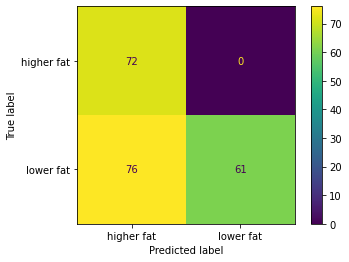

In [44]:
evaluate_best_model(svc_gamma_C_search,X_test,y_test)

From the classification report and confusion matrix above, we can see that our model obtained a 100% recall score on our test set, meaning that it was able to identify all items belonging to the positive class as being part of the poisitive class (no false negatives, as indicated by the top right quadrant of the confusion matrix). However, our precision is only 49% i.e. of the items predicted as being part of the positive class, only 49% were actually part of the positive class. Because we are optimizing based on recall, it is expected to obtain a lower precision score (more false positives) as we are saying that a false negative is less desirable than a false positive.

#### 3.9.2 Random Forest Classifier
Now let's tune our second best performing model, RandomForestClassifier. We will begin with max_depth hyperparameter tuning. We will use grid search as max_depth takes on discrete values and the number of values being tested is not computationally difficult.

In [45]:
# Add search range for max_depth hyperparameter to Random Forest dictionary
rf_clf['classifier__max_depth'] = np.arange(1,20,1)

In [46]:
# Fit Grid Search object on X_train and y_train using hyperparameters from RFC dictionary
rf_md_search = base_cv.grid_search(rf_clf)
print_best_validation(rf_md_search)

Parameters with Best validation Score:
{'classifier': RandomForestClassifier(class_weight='balanced', max_depth=17, random_state=777), 'classifier__class_weight': 'balanced', 'classifier__max_depth': 17, 'classifier__random_state': 777}

Best Validation Score:
0.7552955665024631


In [47]:
# Create dataframe of max_depth values and train and test scores
rf_md_search_df = cv_score_df(rf_md_search,'param_classifier__max_depth',20)

# Cast max_depth to float for graphing
rf_md_search_df = rf_md_search_df.assign(param_classifier__max_depth=rf_md_search_df['param_classifier__max_depth'].astype(float))
rf_md_search_df.head(5)

,param_classifier__max_depth,mean_train_score,mean_test_score
16,17.0,0.964252,0.755296
10,11.0,0.930837,0.751724
12,13.0,0.952596,0.751478
8,9.0,0.902099,0.748276
18,19.0,0.966196,0.744828


In [48]:
# Create plot of train an validation scores for max_depth values
rf_md_train_val_plot = alt.Chart(rf_md_search_df).mark_line().transform_fold(
    fold=['mean_test_score','mean_train_score'],
    as_=['score_type','score']
).encode(
    x=alt.X('param_classifier__max_depth:Q'),
    y=alt.Y('score:Q'),
    color=alt.Color('score_type:N')
).properties(title='Fig 4. Random Forest Classifier Max Depth Train and Validation Scores')
rf_md_train_val_plot

alt.Chart(...)

The highest scoring max_depth in our search range was 17, with a mean validation score of 75.53%. Tuning the max_depth hyperparameter alone resulted in a 1 percentage point increase in mean validation score. Let's try tuning max_depth and min_samples_split together and see if we see any more improvement in performance. We will use randomized search as the search space for max_depth and min_samples_split together is quite large.

In [49]:
# Add discrete search range for min_samples_split hyperparameter to Random Forest dictionary
rf_clf['classifier__min_samples_split'] = np.arange(2,41,1)

In [50]:
rf_md_mss_search = base_cv.random_search(search_space=rf_clf,n_iter=500)

In [51]:
print_best_validation(rf_md_mss_search)

Parameters with Best validation Score:
{'classifier__random_state': 777, 'classifier__min_samples_split': 40, 'classifier__max_depth': 15, 'classifier__class_weight': 'balanced', 'classifier': RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_split=40, random_state=777)}

Best Validation Score:
0.7868226600985222


The highest scoring combination of max_depth and min_samples_split in our search space was a max_depth of 15 and min_samples_split of 40. This showed a mean validation score of 78.68% which is a 3 percentage point improvement on a max_depth alone of 17, and a 4 percentage point increase over our Random Forest classifier with default hyperparameter values.

Let's evaluate our Random Forest model on our test set to see how well it generalizes.

Test Set Classification Report:
              precision    recall  f1-score   support

  higher fat       0.78      0.81      0.79        72
   lower fat       0.90      0.88      0.89       137

    accuracy                           0.86       209
   macro avg       0.84      0.84      0.84       209
weighted avg       0.86      0.86      0.86       209


Test Set Confusion Matrix:


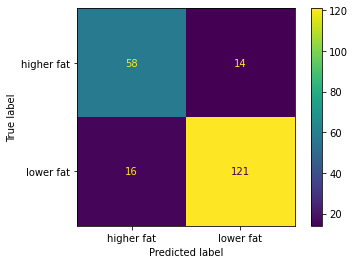

In [52]:
evaluate_best_model(rf_md_mss_search,X_test,y_test)

From the classification report and confusion matrix above, we can see that the recall score for our Random Forest model is 81%, meaning that 81% of the 'higher fat' cheeses in the test set were correctly predicted. The precision score is 78%, meaning that 78% of the cheeses predicted to be positive were actually positive. We do see that our results contain some false negatives (upper right quadrant). The false negative rate is 19%.

#### 3.9.3 Logistic Regression
Finally, let's tune our Logistic Regression model. First, we will tune the penalty hyperparameter and see which performs better.

In [53]:
# Add penalty to Logistic Regression search space
lr_clf['classifier__penalty'] = ['l2','none']

In [54]:
lr_penalty_search = base_cv.grid_search(search_space=lr_clf)
print_best_validation(lr_penalty_search)

Parameters with Best validation Score:
{'classifier': LogisticRegression(class_weight='balanced', random_state=777), 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__random_state': 777}

Best Validation Score:
0.7439655172413794


In [55]:
lr_penalty_search_df = cv_score_df(lr_penalty_search,'param_classifier__penalty',2)
lr_penalty_search_df

,param_classifier__penalty,mean_train_score,mean_test_score
0,l2,0.811200,0.743966
1,none,0.815094,0.740394


The model with the l2 penalty produced a slightly better mean validation score than no penalty, at 74.39 percent. This is the same performance as the model with default hyperparameter settings and l2 is the default setting for this classifier. Let's try tuning the hyperparameter C to see if we can get any performance improvement.

In [56]:
# Add range of values for C to Logistic Regression dictionary
lr_clf['classifier__C'] = scipy.stats.uniform(0,0.1)

In [57]:
lr_C_search = base_cv.random_search(search_space=lr_clf,n_iter=500)
print_best_validation(lr_C_search)

Parameters with Best validation Score:
{'classifier': LogisticRegression(C=0.0006235832020958899, class_weight='balanced',
                   random_state=777), 'classifier__C': 0.0006235832020958899, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__random_state': 777}

Best Validation Score:
0.7997536945812808


In [58]:
lr_C_df = cv_score_df(lr_C_search,['param_classifier__penalty','param_classifier__C'],5)
lr_C_df 

,param_classifier__penalty,param_classifier__C,mean_train_score,mean_test_score
198,l2,0.000624,0.789809,0.799754
400,l2,0.000817,0.789420,0.796305
432,l2,0.000241,0.790198,0.796305
387,l2,0.000364,0.789811,0.796305
474,l2,0.002388,0.787479,0.792857


The model with a C value of 0.000624 performed the best, with an mean validation score of 79.97%. This is an improvement by over 5 percentage points from the default model.

Let's evaluate our model on our test set to see how well it generalizes.

Test Set Classification Report:
              precision    recall  f1-score   support

  higher fat       0.64      0.75      0.69        72
   lower fat       0.85      0.77      0.81       137

    accuracy                           0.77       209
   macro avg       0.75      0.76      0.75       209
weighted avg       0.78      0.77      0.77       209


Test Set Confusion Matrix:


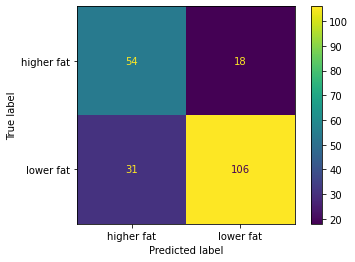

In [59]:
evaluate_best_model(lr_C_search, X_test,y_test)

From the classification report and confusion matrix above, we can wee that the recall score for our Logistic Regression model is 75%, meaning that 75% of the 'higher fat' cheeses were correcly predicted. The precision for this model is 64%, meaning that 64% of the cheeses predicted to be 'higher fat' actually were higher fat.

Linear regression is an iterpretable model. We can see which features contribute most to classifying a cheese to be in the positive class, and which features contribute the most to classifying a cheese to be in the negative class. Positive coefficients mean that the feature pushes the prediction more towards the positive class, while negative coefficients mean that the feature pushes the prediction more towards the negative class. Let's find our features and their associated coefficients.

In [60]:
# Find feature coefficients
lr_coefs = lr_C_search.best_estimator_['classifier'].coef_[0].tolist()

In [61]:
# Create imputed categorical features
imputed_categorical_feats = categorical_transformer['simpleimputer'].fit_transform(X_train.loc[:,categorical_feats])

In [62]:
# Fit and transform categorical features
categorical_transformer['onehotencoder'].fit_transform(imputed_categorical_feats);

In [63]:
# Find transformed feature names and save to list
categorical_feat_names = categorical_transformer['onehotencoder'].get_feature_names().tolist()

In [64]:
# Combine all feature names-- numeric, categorical and binary
all_feats = ['MoisturePercent_MoisturePercent']
all_feats.extend(categorical_feat_names)
all_feats.extend(['Organic_Organic'])

In [65]:
# Create dictionary for df columns
feature_lr_coefs = {'feature':all_feats,'coefficient':lr_coefs}

# Create dataframe
feat_coef_df = None
feat_coef_df = pd.DataFrame(feature_lr_coefs).sort_values(by='coefficient', ascending=False)
feat_coef_df[['original_feature','OHE_feature']]= feat_coef_df['feature'].str.split("_",1, expand=True)
feat_coef_df = feat_coef_df.sort_values(by=['original_feature','coefficient'], ascending=False)
feat_coef_df = feat_coef_df.assign(original_feature=feat_coef_df['original_feature'].map({
    'x0':'ManufacturerProvCode',
    'x1':'ManufacturingTypeEn',
    'x2':'MilkTypeEn',
    'x3':'MilkTreatmentTypeEn',
    'x4':'RindTypeEn',
    'x5':'CategoryTypeEn',
    'Organic':'Organic',
    'MoisturePercent':'MoisturePercent'})
                                  ).drop(columns='feature')
feat_coef_df

,coefficient,original_feature,OHE_feature
33,0.015082,CategoryTypeEn,Fresh Cheese
35,0.014053,CategoryTypeEn,Semi-soft Cheese
36,0.010807,CategoryTypeEn,Soft Cheese
38,0.001185,CategoryTypeEn,missing_value
37,-0.000689,CategoryTypeEn,Veined Cheeses
34,-0.002422,CategoryTypeEn,Hard Cheese
32,-0.038015,CategoryTypeEn,Firm Cheese
30,0.005689,RindTypeEn,Washed Rind
27,0.001214,RindTypeEn,Bloomy Rind
31,0.000038,RindTypeEn,missing_value


In [66]:
top_5_features = feat_coef_df.sort_values(by='coefficient',ascending=False).head(5)
top_5_features

,coefficient,original_feature,OHE_feature
0,0.114735,MoisturePercent,MoisturePercent
21,0.020295,MilkTypeEn,Goat
23,0.019932,MilkTreatmentTypeEn,Pasteurized
33,0.015082,CategoryTypeEn,Fresh Cheese
35,0.014053,CategoryTypeEn,Semi-soft Cheese


Let's look at the features with the top 5 positive coefficients. MoisturePercent looks to be the most influential feature for this Logistic Regression model, with a positive coefficient of 0.114735. It is over 5 times more influential than the next most influential feature, which is the goat milk type. Cheeses that are pasteurized also push the prediction model towards 'higher fat', along with cheeses categorized as fresh cheese or semi-soft cheese.

In [67]:
bottom_5_features = feat_coef_df.sort_values(by='coefficient').head(5)
bottom_5_features

,coefficient,original_feature,OHE_feature
32,-0.038015,CategoryTypeEn,Firm Cheese
15,-0.016496,MilkTypeEn,Cow
24,-0.012838,MilkTreatmentTypeEn,Raw Milk
2,-0.008671,ManufacturerProvCode,BC
11,-0.006889,ManufacturingTypeEn,Artisan


A cheese categroized as a firm cheese will push the prediction model the most toward predicting the 'lower fat' category, followed by a cheese made of cows milk, then raw milk. Cheeses made in BC, along with cheeses made by an artisan cheese maker would also push the model towards predicting the 'lower fat' class.

#### 3.9.4 Dummy Classifier
Let's fit our Dummy Classifier and evaluate it on our test set to use as a baseline against which we can compare our other models.

In [68]:
dummy_score = base_cv.grid_search(search_space=dm_clf)
print_best_validation(dummy_score)

Parameters with Best validation Score:
{'classifier': DummyClassifier(random_state=777, strategy='stratified'), 'classifier__random_state': 777, 'classifier__strategy': 'stratified'}

Best Validation Score:
0.24495073891625618


Test Set Classification Report:
              precision    recall  f1-score   support

  higher fat       0.32      0.31      0.31        72
   lower fat       0.65      0.66      0.65       137

    accuracy                           0.54       209
   macro avg       0.48      0.48      0.48       209
weighted avg       0.53      0.54      0.54       209


Test Set Confusion Matrix:


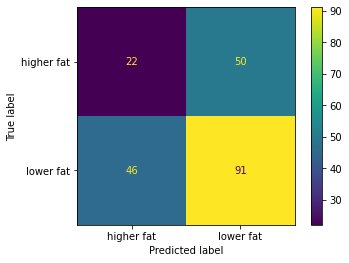

In [69]:
evaluate_best_model(dummy_score, X_test,y_test)

From the classification report and confusion matrix above, we can see that the recall score for the Dummy Classifier is 31%, meaning that the dummy model was able to correctly predict the positive class only 31% of the time. The precision score for the dummy model is 32%, meaning that of the cheeses predicted to be 'higher fat', only 32% were actually 'higher fat'.

## 4. Discussion
In this exercise, we trained and tested 4 different classifier models: Dummy Classifier, Support Vector Classifier, Random Forest Classifier and Logistic Regression. Our aim was to find the model with the best recall performance in identifying cheeses with higher fat content after training on our training set and evaluating on our test set.

The Support Vector Classifier showed the highest recall score of all models with a score of 100%. It was able to predict all members of the positive class, 'higher fat', correctly. There were no false negatives. The precision score of this model, however, was much lower, at 49%, meaning that of all cheeses predicted to be 'higher fat', only 49% of them were predicted correctly. The accuracy of this model is 64% meaning that out of all the cheeses, it was able to predict the class, whether 'higher fat' or 'lower fat' (positive or negative class) correctly 64% of the time.

Comparing our Support Vector Classifier to our dummy model, our Support Vector Classifier is performing better on recall, precision and accuracy. Our dummy model only showed a recall score of 31%, meaning that it was only able to correctly identify 31% of the 'higher fat' cheeses versus our Support Vector Classifier performance of 100%. This is a 69 percentage point difference, and more than two times better performance. On precision, our Support Vector Classifier performed much better than our dummy model as well. Of the cheeses that our dummy model predicted to be 'higher fat' only 32% actually were actually higher fat, while of the cheeses that our Support Vector Classifier predicted to be 'higher fat', 49% were actually higher fat. When it comes to accuracy, our dummy model predicted the correct FatLevel class 54% of the time, while our Support Vector Classifier was able to predict the correct class 64% of the time.

When measuring a model's recall, it is important to also take precision into consideration. A dummy classifier that predicts the positive class 100% of the time will achieve a recall score of 100%, but may have low precision, depending on the ratio of the positive class to the negative class. In this scenario, the precision will be equivalent to the percentage of examples belonging to the positive class, which in a highly unbalanced dataset where the positive class is the minority class, would be very low. If we were to score a dummy classifier predicting the positive class 100% of the time on our test set, the dummy classifier would achieve 100% recall, but only 34% precision (72 true positives out of 209 positive predictions). Our Support Vector Classifier shows an equivalent recall to this hypothetical dummy classifier, but a better precision score at 49%. Our Support Vector Classifier is not only able to identify members of the positive class correctly, it is also able to identify members of the negative class correctly, which the dummy classifier that always predicts the positive class is unable to do.

Of the other models that we tested, Random Forest performed the second best as far as recall, with a score of 81%, followed by our Logistic Regression model at 75% recall. They had a precision score of 78% and 64% respectively.

Although our Support Vector Classifier was able to identify all 'high fat' cheeses, its precision in doing so was not spectacular. In answering our initial question of which cheeses were of higher fat content and thus should be added to a 'cheeses to avoid' list, the classifier did a great job of identifying the 'higher fat' cheeses correctly, but not so great at identifying the 'lower fat' cheeses correctly. This would mean that our list of 'cheeses to avoid' would contain all 'high fat' cheeses which is the aim, but also a lot of 'lower fat' cheeses that those with heart disease could safely enjoy, which is not ideal. If we were using the classifier as a preliminary tool to reduce the amount of cheeses that needed to be tested for fat level, we would be testing a lot of cheeses unnecessarily. Ideally, our classifier would maximize our true positives, and minimize our false positives. We could use our F1 scorer to help achieve this, however, our goal was to maximize recall, which, with our model, had a consequence of reducing precision.

How could we improve the performance of our model? As always, we could collect more data so that we could train our model on more examples so it becomes more adept at identifying the 'higher fat' class. Barring that, we could look at feature reduction to reduce the amount of noise in our data, removing features that are not good predictors of cheese fat level in our model as a whole, or features that are highly correlated with other features and thus are redundant. This would also make our model more interpretable, since we would have fewer features and the interactions between them to consider. Another technique to improve performance of our model could be to group low frequency categorical labels together, for instance, in our model, grouping all milk types below 10 examples together in a new 'other' category.

## 5. References
Eat to lower your cholesterol. (2016, November 3). Heart and Stroke Foundation of Canada. Retrieved March 4, 2022, from https://www.heartandstroke.ca/articles/eat-to-lower-your-cholesterol

Public Health Agency of Canada. (2017, February 10). Heart Disease in Canada - Canada.ca. Government of Canada. Retrieved March 4, 2022, from https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html

Markham, K. (2021, October 6). Scikit-learn tip #49- Tune Multiple Models. Nbviewer.Org. Retrieved March 1, 2022, from https://nbviewer.org/github/justmarkham/scikit-learn-tips/blob/master/notebooks/49_tune_multiple_models.ipynb

Markham, K. (2021a, August 24). Scikit-learn tip #31- Shuffle your dataset when using cross_val_score. Nbviewer.Org. Retrieved March 1, 2022, from https://nbviewer.org/github/justmarkham/scikit-learn-tips/blob/master/notebooks/31_kfold_shuffle.ipynb

Module 5: Preprocessing Numerical Features, Pipelines and Hyperparameter Optimization ·. (n.d.). Introduction to Machine Learning. Retrieved 20200–03-04, from https://ml-learn.mds.ubc.ca/en/module5/Module 5, Slide Deck 17, Slide 16- continuous hyperparameter range

cheese_data.csv obtained from Introduction to Machine Learning final project folder.